In [1470]:
# Sample Dataset = "https://www.kaggle.com/datasets/mohithsairamreddy/salary-data/data"
# Job Role Group Mapping = "https://support.joinhandshake.com/hc/en-us/articles/360033423494-About-Job-Roles-and-Job-Role-Groups-Employers"

In [1471]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from scipy.stats import t
from scipy.stats import chi2_contingency
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1472]:
# Reading in the data

# Sample
df = pd.read_csv(r"/Users/shrutidua/Downloads/Salary_Data.csv")

# Job category mapping
job_role_group = pd.read_excel(r"/Users/shrutidua/Desktop/Copy of Job Role Groups in Handshake 2.2.21.xlsx")

# Data Structure and Cleaning

In [1473]:
# First glance at the Sample Data

pd.set_option('display.max_columns', None)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [1474]:
# Shape and feature information

df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [1475]:
# Looking for missing values

df.isna().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

Sincle missing values are a very small portion of the data, we can drop the null values

In [1476]:
df = df.dropna()

In [1477]:
# Checking for duplicates

df.duplicated(keep="first").sum()

4911

In [1478]:
# Dropping the duplicates

df = df.drop_duplicates(keep = "first")
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6623,43.0,Female,Master's Degree,Digital Marketing Manager,15.0,150000.0
6624,27.0,Male,High School,Sales Manager,2.0,40000.0
6625,33.0,Female,Bachelor's Degree,Director of Marketing,8.0,80000.0
6628,37.0,Male,Bachelor's Degree,Sales Director,7.0,90000.0


In [1479]:
# Rechecking the Shape and feature information
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1787 entries, 0 to 6631
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1787 non-null   float64
 1   Gender               1787 non-null   object 
 2   Education Level      1787 non-null   object 
 3   Job Title            1787 non-null   object 
 4   Years of Experience  1787 non-null   float64
 5   Salary               1787 non-null   float64
dtypes: float64(3), object(3)
memory usage: 97.7+ KB


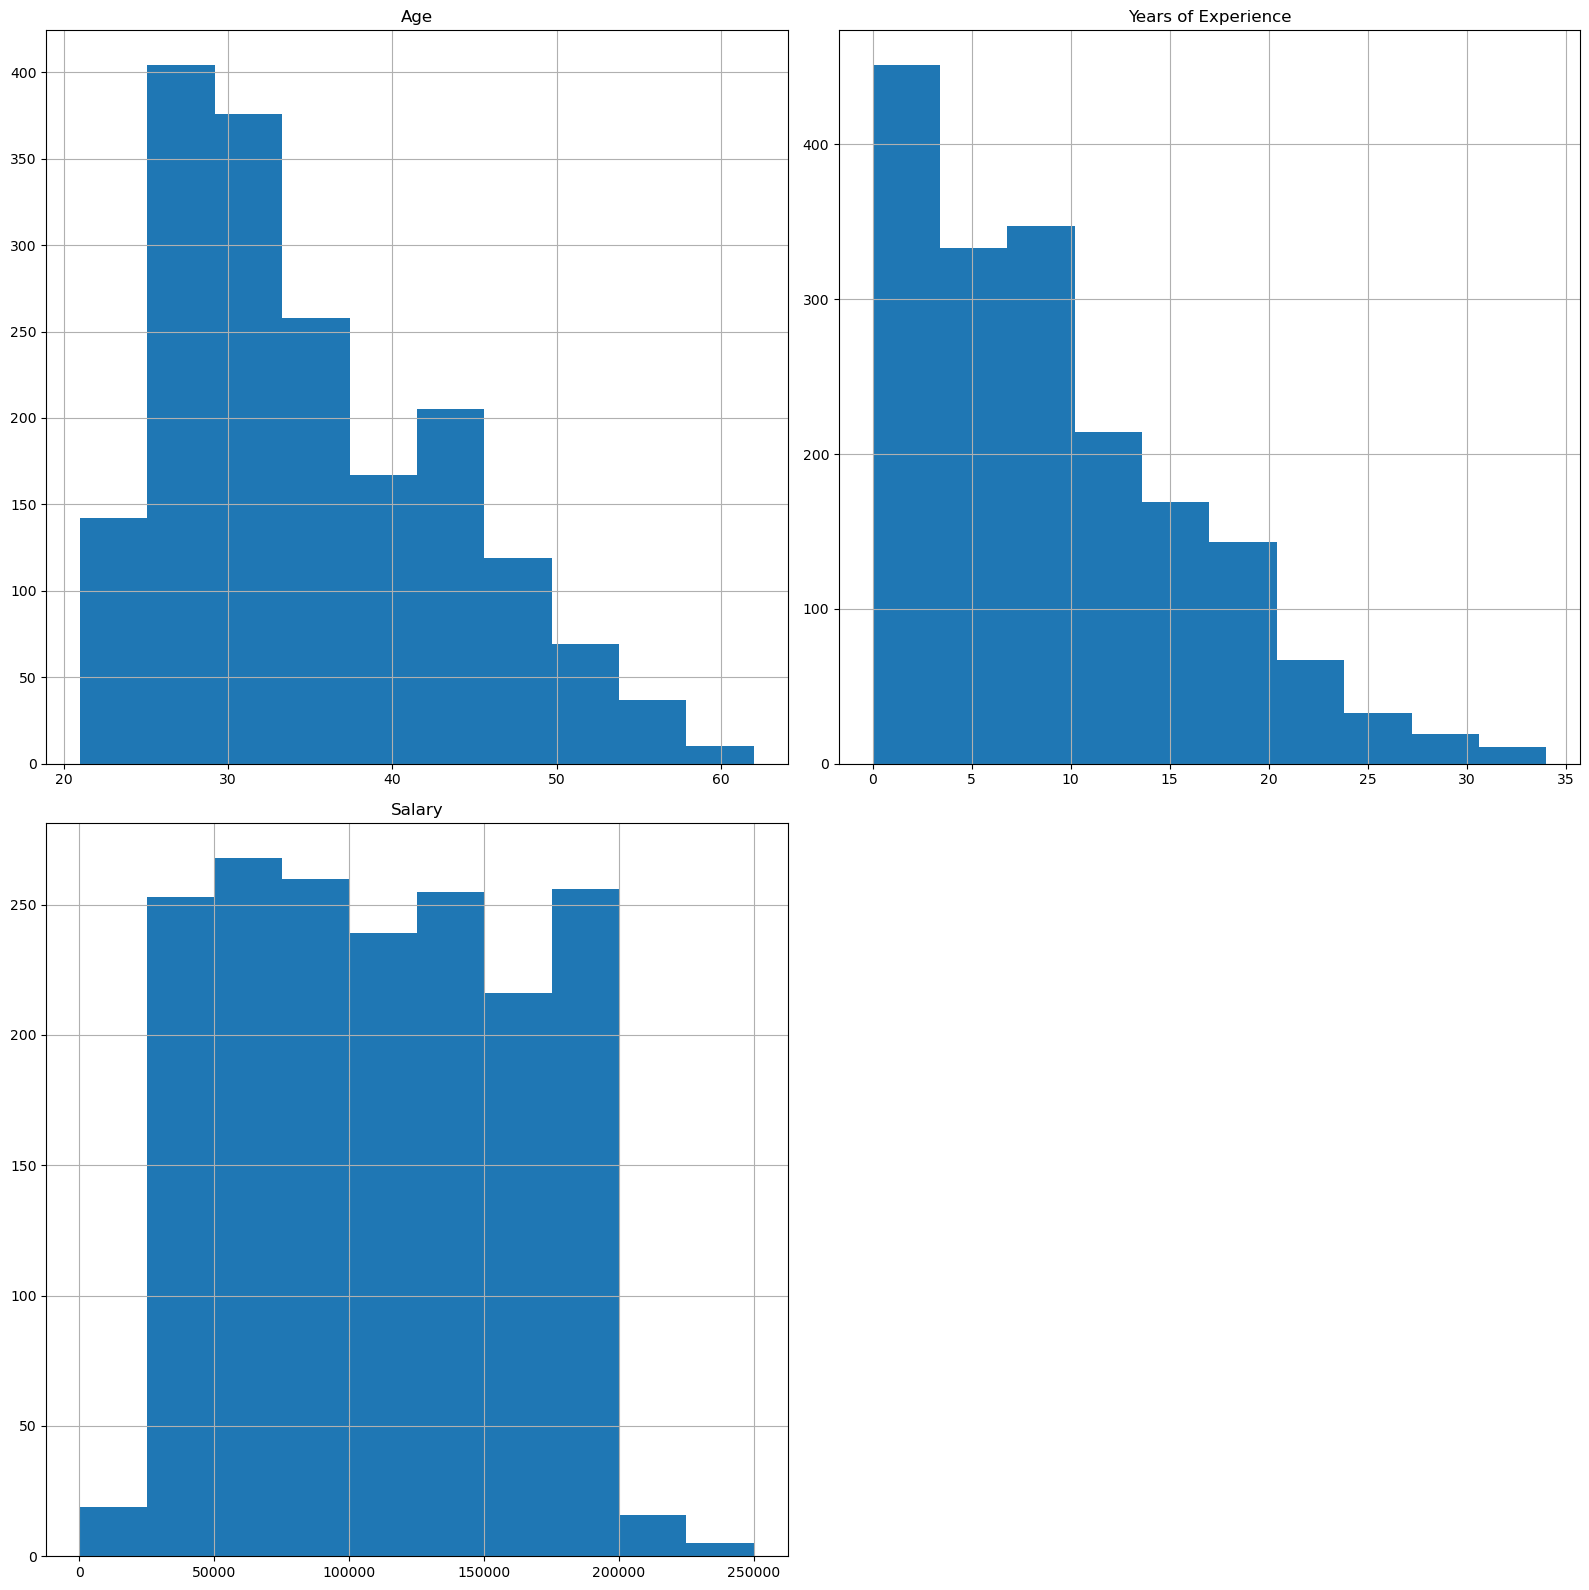

In [1480]:
# Looking at variable distributions to understand distriution of each numeric variable, identify potential outliers, 
# and identify if normalization or scaling of features is needed.

df.hist(figsize = (16,16))
plt.tight_layout()
plt.show()

We can see the ranges of the three variables are very different and might require scaling to allow accurate prediction

# Statistical Analysis of the Relationship between Years of Experience and Salary

To begin with our analysis, I will start by analysing the relationship between Years of Experience and Salary only. 

# Descriptive Statistics

In [1481]:
sdf = df[["Years of Experience", "Salary"]]
sdf

,Years of Experience,Salary
0,5.0,90000.0
1,3.0,65000.0
2,15.0,150000.0
3,7.0,60000.0
4,20.0,200000.0
...,...,...
6623,15.0,150000.0
6624,2.0,40000.0
6625,8.0,80000.0
6628,7.0,90000.0


In [1482]:
sdf.describe()

,Years of Experience,Salary
count,1787.000000,1787.000000
mean,9.156128,113184.659765
std,6.844924,51596.536766
min,0.000000,350.000000
25%,3.000000,70000.000000
50%,8.000000,110000.000000
75%,13.000000,160000.000000
max,34.000000,250000.000000


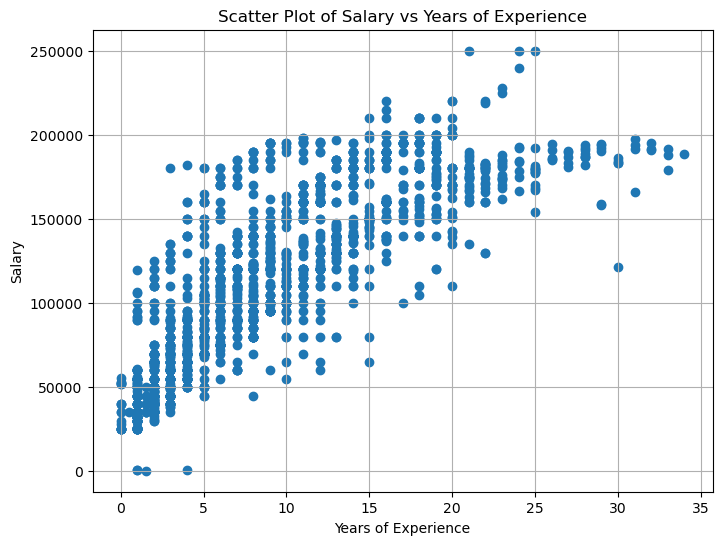

In [1483]:
# Sample data
x = sdf['Years of Experience']  # X-axis data
y = sdf['Salary']               # Y-axis data

# Scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.title('Scatter Plot of Salary vs Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

We can see that there might be a correalation between Years of Experience and Salary. To statistically conclude this, we carry out hypothesis testing.

# Hypothesis Testing

We will be using a two-tailed test to determine the existence of correlation between Years of Exerience 
and Salary (using the correlation coefficient ρ)

Null Hypothesis (H0) - There is no correlation between Years of Experience and Salary (ρ = 0)

Alternative Hypothesis (H1) - There is correlation between Years of Experience and Salary (ρ != 0)

Significance level = 0.05

In [1484]:
# Significance Level

alpha = 0.05
print(f"Significance level = {alpha}")

# Sample

n = df.shape[0]
print(f"Sample = {n}")

# Pearson Correlation Coefficient

r = np.corrcoef(x, y)[0, 1]
print(f"Correlation Coefficient = {r}")

# t-statistic

t_value = r / np.sqrt((1 - r**2) / (n - 2))
print(f"T-statistic = {t_value}")

# Degrees of Freedom
degreesf = n - 2

# p-value
p_value_lower = t.cdf(-np.abs(t_value), degreesf)
p_value_upper = 1 - t.cdf(t_value, degreesf)
p_value = p_value_lower + p_value_upper
print(f"p_value = {p_value}")

# USING SCIPY

from scipy.stats import pearsonr
# r
r_scipy = pearsonr(x, y).statistic
print(f"Correlation Coefficient from scipy = {r_scipy}")

# p_value

p_scipy = pearsonr(x, y).pvalue
print(f"p_value from scipy = {p_scipy}")

# Conclusion

decision = (p_value <= alpha) & (p_scipy <= alpha)

if decision == True:
    print("Since p_value <= alpha, we reject null hypothesis")
else:
    print("Since p_value > alpha, we reject alternative hypothesis")

Significance level = 0.05
Sample = 1787
Correlation Coefficient = 0.8187248425666487
T-statistic = 60.2427007588725
p_value = 0.0
Correlation Coefficient from scipy = 0.8187248425666481
p_value from scipy = 0.0
Since p_value <= alpha, we reject null hypothesis


Hence, we can conclude that there is correlation between Years of Experience and Salary with a high Pearson Correlation Coefficient value of 0.8187. 

# Regression Analysis

We will now use Linear Regression to understand how much the dependent variable, Salary, changes as the independent variable, Years of Experience, change, and whether we can use the independent variable to predict the dependent variable

In [1485]:
# Regression analysis 

x = sdf['Years of Experience']  # X-axis data
y = sdf['Salary']    

# Scaling the values to be able to analyse effectively
scaler = StandardScaler()
y = y.values.reshape(-1, 1)
y_scaled = scaler.fit_transform(y)
x = x.values.reshape(-1, 1)
x_scaled = scaler.fit_transform(x)

# Splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

# Create and fit the model on the training data
model = LinearRegression().fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [1486]:
# Evaluation of model on test data
rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = model.score(X_test, y_test)
print(f"Root Mean Squared Error (Test Data): {rmse}")
print(f"R-squared Value (Test Data): {r2}")

# Evaluation of model on training data
rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = model.score(X_train, y_train)
print(f"Root Mean Squared Error (Training Data): {rmse_train}")
print(f"R-squared Value (Training Data): {r2_train}")

Root Mean Squared Error (Test Data): 0.6219413512871822
R-squared Value (Test Data): 0.6243738916439696
Root Mean Squared Error (Training Data): 0.561677408232054
R-squared Value (Training Data): 0.6821443238789355


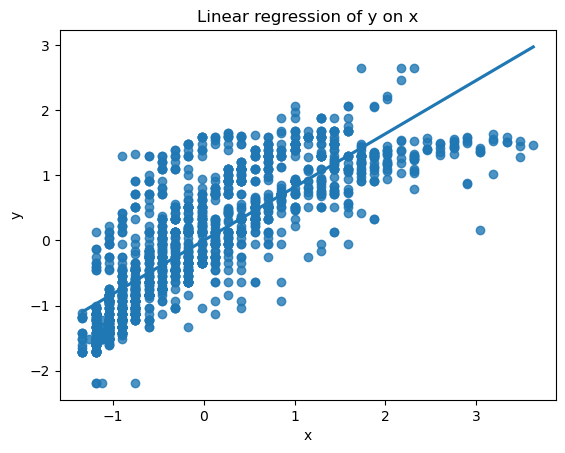

In [1487]:
# Visualizing the regression line

# Plot the data points and the regression line
sns.regplot(x=x_scaled, y=y_scaled, ci=None)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear regression of y on x")
plt.show()

Hence, we can conclude that Years of Experience can be used to predict the Salary of a person but with low R^2 value and higher RMSE values. Hence, we need to make the model predictions better. Which of the other features like Age, Gender, Education Level, and Job Title can be used to predict the Salary? We will analyse the relationship between these features and Salary using the Chi-square test and then incorporate the results into our linear regression model.

# Analysis of All features other than Years of Experience

In [1488]:
# Before we carry out the Chi-square test, we will look analyse the other features

df.corr()

,Age,Years of Experience,Salary
Age,1.000000,0.936260,0.766841
Years of Experience,0.936260,1.000000,0.818725
Salary,0.766841,0.818725,1.000000


As we can see, Age and Years of Experience have a high correlation. Since Linear Regression models assume no multicollinearity and we have seen that Years of Experience has a strong effect on Salary, we will drop Age.

In [1489]:
df = df.drop(["Age"], axis = 1)
df

,Gender,Education Level,Job Title,Years of Experience,Salary
0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,Female,Master's,Data Analyst,3.0,65000.0
2,Male,PhD,Senior Manager,15.0,150000.0
3,Female,Bachelor's,Sales Associate,7.0,60000.0
4,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...
6623,Female,Master's Degree,Digital Marketing Manager,15.0,150000.0
6624,Male,High School,Sales Manager,2.0,40000.0
6625,Female,Bachelor's Degree,Director of Marketing,8.0,80000.0
6628,Male,Bachelor's Degree,Sales Director,7.0,90000.0


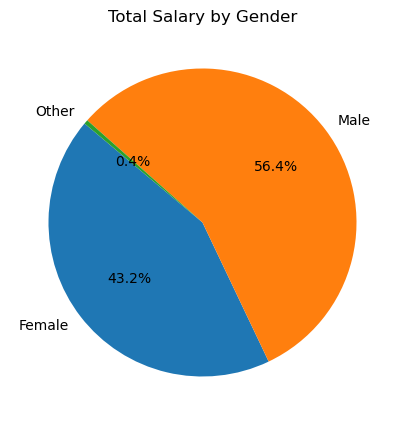

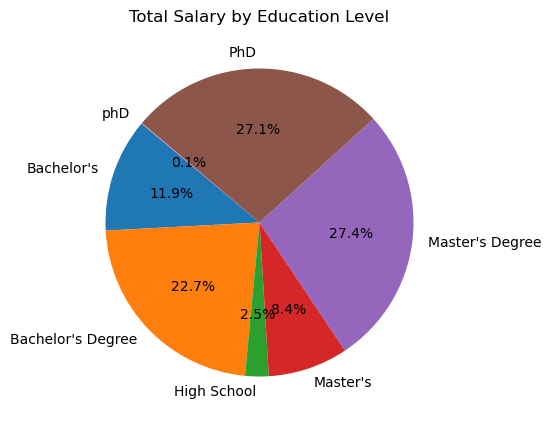

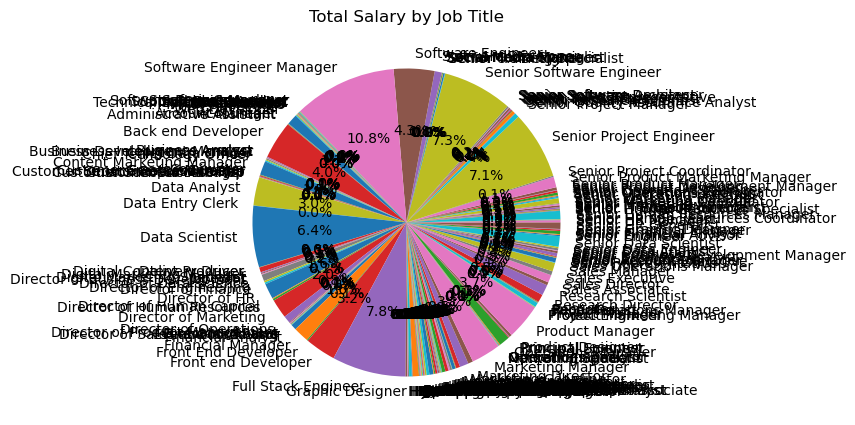

In [1490]:
# Analysing the total Salary by Categorical Variables

CategoricalVar = ["Gender", "Education Level", "Job Title"]

for var in CategoricalVar:
    plt.figure(figsize=(5, 5))
    plt.pie(df.groupby(var)['Salary'].sum(), labels=df.groupby(var)['Salary'].sum().index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Total Salary by {var}')
    plt.show()

As you can see, there are many jobs that are the similar by definition but differ in name or grammar. Tagging each title to a generic job category would help understanding the data more.

After research, I was able to find a mapping from Handshake that provides more than 380 Job Role groups, identified by their team using data such as career interests, majors, user research, and job details

In [1491]:
# Adding Job Role Group data

df = pd.merge(df, job_role_group, left_on='Job Title', right_on='Job Role', how='left')
df = df.drop(['Job Role', 'Job Title'], axis=1)
df

,Gender,Education Level,Years of Experience,Salary,Job Role Group
0,Male,Bachelor's,5.0,90000.0,Software Developers and Engineers
1,Female,Master's,3.0,65000.0,Data Analysts
2,Male,PhD,15.0,150000.0,NaN
3,Female,Bachelor's,7.0,60000.0,NaN
4,Male,Master's,20.0,200000.0,NaN
...,...,...,...,...,...
1782,Female,Master's Degree,15.0,150000.0,NaN
1783,Male,High School,2.0,40000.0,Sales Managers
1784,Female,Bachelor's Degree,8.0,80000.0,NaN
1785,Male,Bachelor's Degree,7.0,90000.0,Sales Managers


In [1492]:
# Dropping rows with unavailable job role groups

df=df.dropna()
df

,Gender,Education Level,Years of Experience,Salary,Job Role Group
0,Male,Bachelor's,5.0,90000.0,Software Developers and Engineers
1,Female,Master's,3.0,65000.0,Data Analysts
5,Male,Bachelor's,2.0,55000.0,Market Research Analysts and Marketing Special...
6,Female,Master's,12.0,120000.0,Product Managers
7,Male,Bachelor's,4.0,80000.0,Sales Managers
...,...,...,...,...,...
1768,Female,Master's Degree,14.0,140000.0,Sales Managers
1777,Male,Master's Degree,14.0,140000.0,Market Research Analysts and Marketing Special...
1783,Male,High School,2.0,40000.0,Sales Managers
1785,Male,Bachelor's Degree,7.0,90000.0,Sales Managers


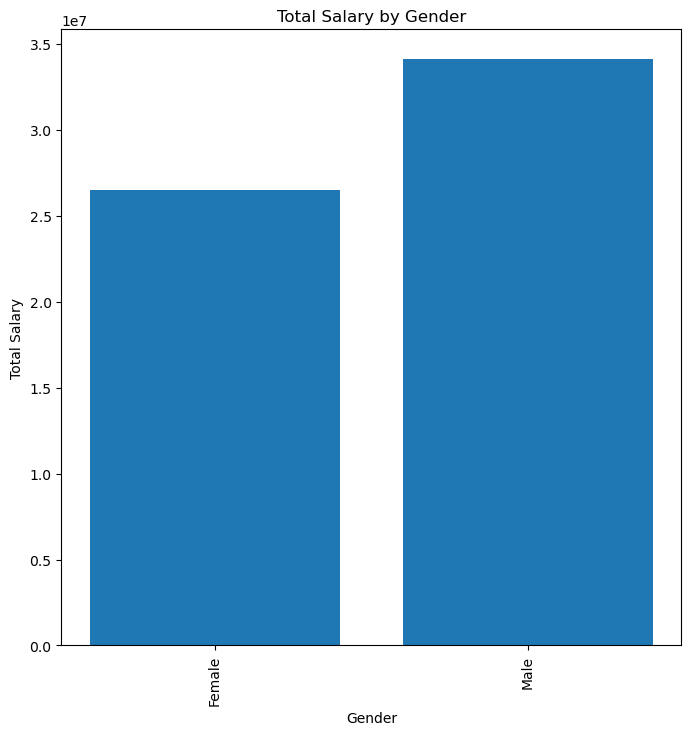

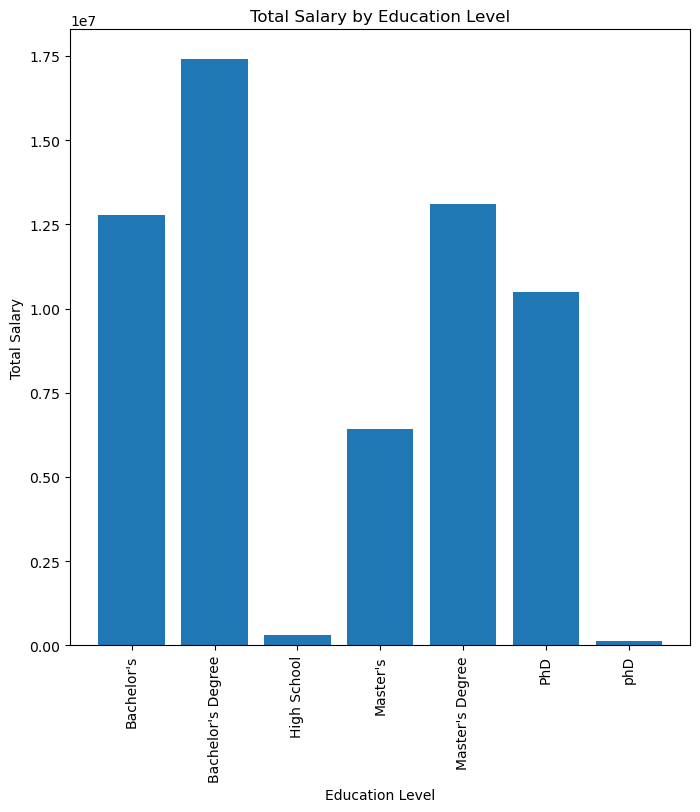

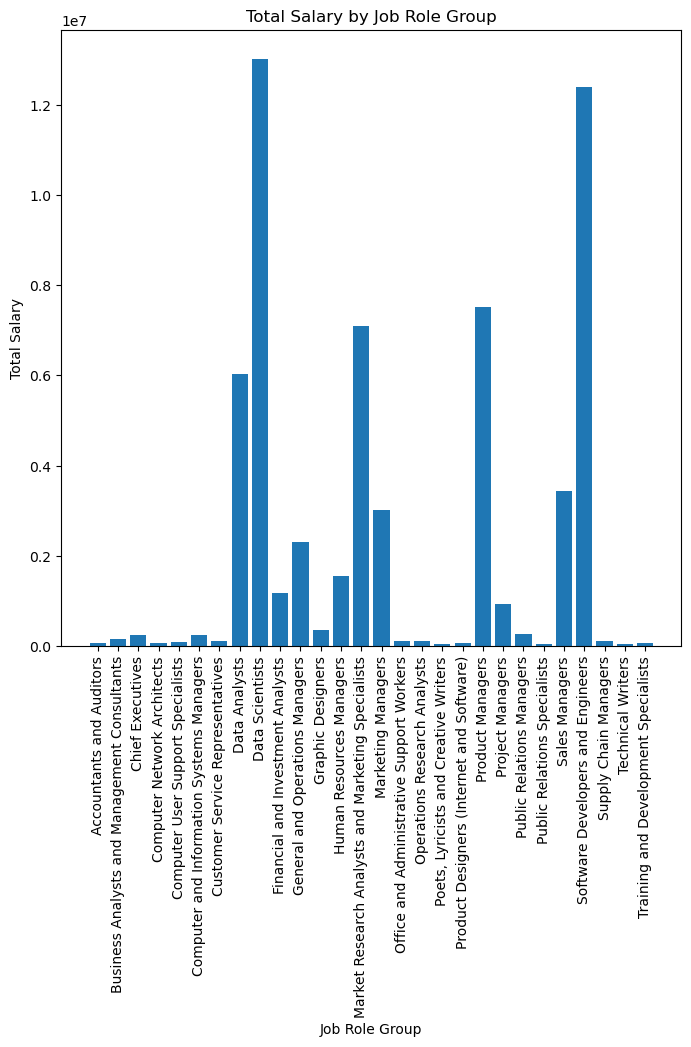

In [1493]:
# Analysing the total Salary by Categorical Variables once more
CategoricalVar = ["Gender", "Education Level", "Job Role Group"]

for var in CategoricalVar:
    mean_salary = df.groupby(var)['Salary'].sum()
    plt.figure(figsize=(8, 8))
    plt.bar(mean_salary.index, mean_salary.values)
    plt.title(f'Total Salary by {var}')
    plt.xlabel(var)
    plt.ylabel('Total Salary')
    plt.xticks(rotation=90)
    plt.show()

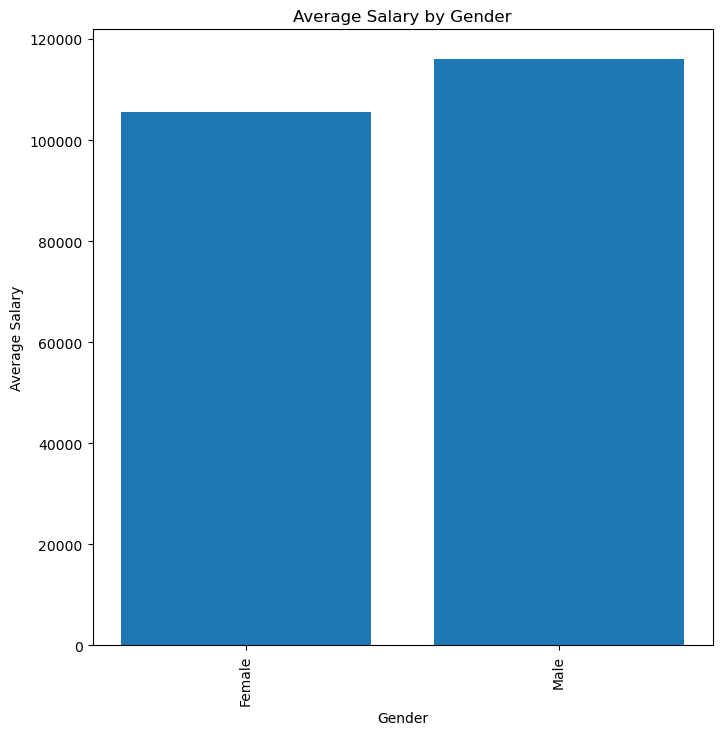

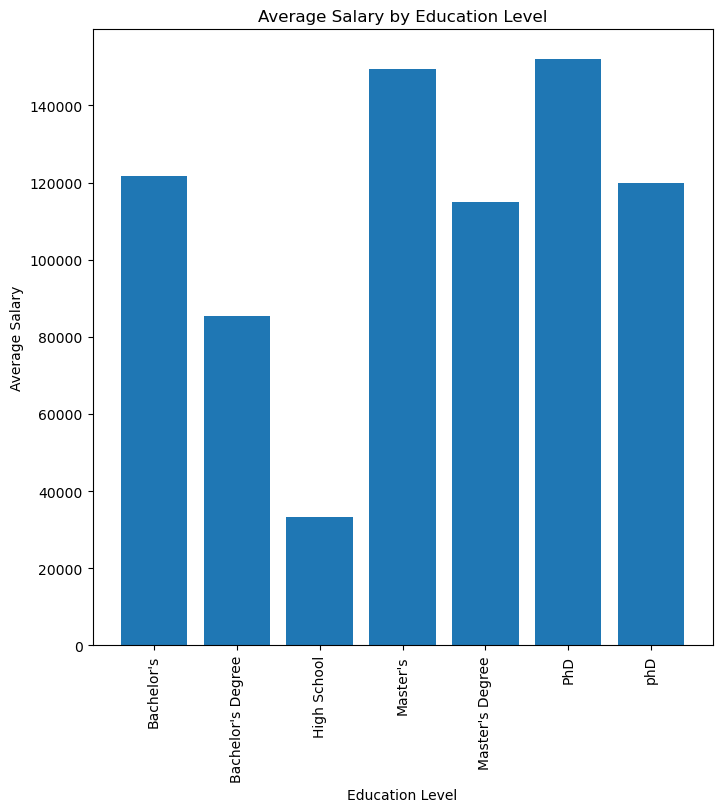

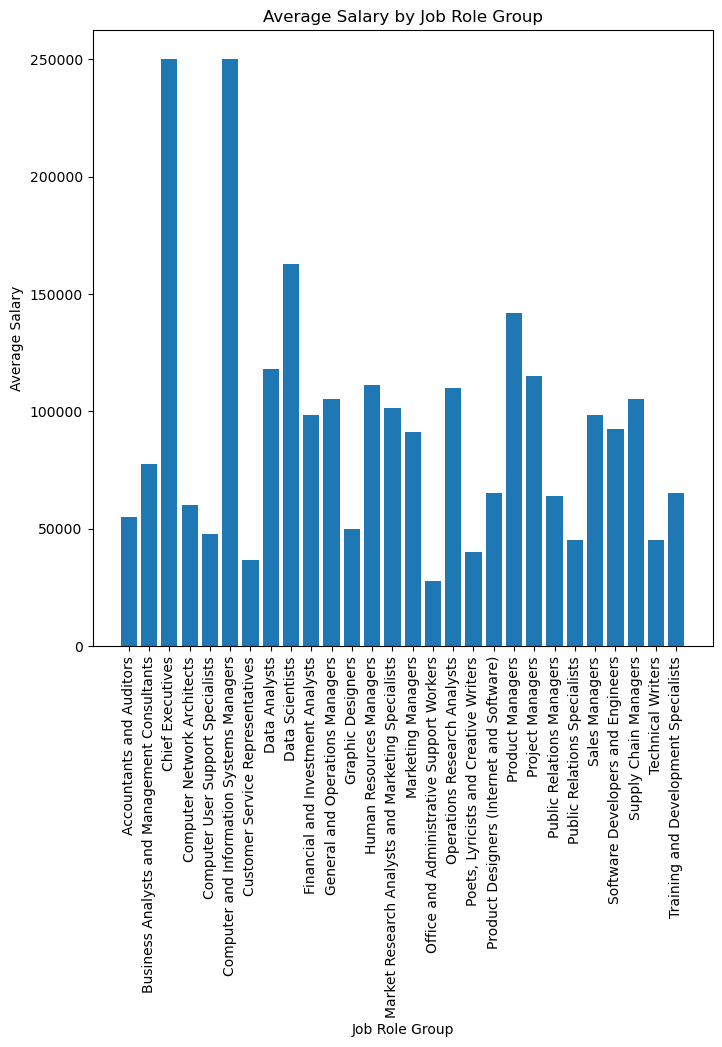

In [1494]:
# Looking at the average salary by Categorical Variable

for var in CategoricalVar:
    mean_salary = df.groupby(var)['Salary'].mean()
    plt.figure(figsize=(8, 8))
    plt.bar(mean_salary.index, mean_salary.values)
    plt.title(f'Average Salary by {var}')
    plt.xlabel(var)
    plt.ylabel('Average Salary')
    plt.xticks(rotation=90)
    plt.show()

Looking at the charts above, we can see that there is a slight difference in total and average salary by gender but by Education Level and Job Role Group, the salries differ significantly by different categories. We will be analysing these relationships further using the Chi-squared Test of Independence.

In [1495]:
def perform_chi_square_test(data, col1, col2):
    
    # Contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    significant = p < 0.05  # 5% significance level
    return p, significant

features_to_test = {
    'Gender and Salary': ('Gender', 'Salary'),
    'Education Level and Salary': ('Education Level', 'Salary'),
    'Job Role Group and Salary': ('Job Role Group', 'Salary')
}

chi_square_results = {aspect: perform_chi_square_test(df, *columns) for aspect, columns in features_to_test.items()}
chi_square_results

{'Gender and Salary': (0.3984767505001714, False),
 'Education Level and Salary': (1.0944593599160743e-22, True),
 'Job Role Group and Salary': (2.5393008321373387e-40, True)}

As we can see, in this sample, gender does not have a statistically significant relation with the Salary. Hence, we will remove it from the dataframe.

In [1496]:
df = df.drop("Gender", axis = 1)

In [1497]:
# Categorical Encoding of Education level and Job Role Group

columns = ["Education Level", "Job Role Group"]
new_columns = pd.get_dummies(df[columns], prefix="type")


In [1498]:
df = df.join(new_columns)
df.head()

,Education Level,Years of Experience,Salary,Job Role Group,type_Bachelor's,type_Bachelor's Degree,type_High School,type_Master's,type_Master's Degree,type_PhD,type_phD,type_Accountants and Auditors,type_Business Analysts and Management Consultants,type_Chief Executives,type_Computer Network Architects,type_Computer User Support Specialists,type_Computer and Information Systems Managers,type_Customer Service Representatives,type_Data Analysts,type_Data Scientists,type_Financial and Investment Analysts,type_General and Operations Managers,type_Graphic Designers,type_Human Resources Managers,type_Market Research Analysts and Marketing Specialists,type_Marketing Managers,type_Office and Administrative Support Workers,type_Operations Research Analysts,"type_Poets, Lyricists and Creative Writers",type_Product Designers (Internet and Software),type_Product Managers,type_Project Managers,type_Public Relations Managers,type_Public Relations Specialists,type_Sales Managers,type_Software Developers and Engineers,type_Supply Chain Managers,type_Technical Writers,type_Training and Development Specialists
0,Bachelor's,5.0,90000.0,Software Developers and Engineers,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Master's,3.0,65000.0,Data Analysts,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Bachelor's,2.0,55000.0,Market Research Analysts and Marketing Special...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Master's,12.0,120000.0,Product Managers,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,Bachelor's,4.0,80000.0,Sales Managers,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [1499]:
df = df.drop(["Education Level", "Job Role Group"], axis = 1)
df.head()

,Years of Experience,Salary,type_Bachelor's,type_Bachelor's Degree,type_High School,type_Master's,type_Master's Degree,type_PhD,type_phD,type_Accountants and Auditors,type_Business Analysts and Management Consultants,type_Chief Executives,type_Computer Network Architects,type_Computer User Support Specialists,type_Computer and Information Systems Managers,type_Customer Service Representatives,type_Data Analysts,type_Data Scientists,type_Financial and Investment Analysts,type_General and Operations Managers,type_Graphic Designers,type_Human Resources Managers,type_Market Research Analysts and Marketing Specialists,type_Marketing Managers,type_Office and Administrative Support Workers,type_Operations Research Analysts,"type_Poets, Lyricists and Creative Writers",type_Product Designers (Internet and Software),type_Product Managers,type_Project Managers,type_Public Relations Managers,type_Public Relations Specialists,type_Sales Managers,type_Software Developers and Engineers,type_Supply Chain Managers,type_Technical Writers,type_Training and Development Specialists
0,5.0,90000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,3.0,65000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,55000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,12.0,120000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,4.0,80000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


We will now repeat the process of creating the Linear Regression model and evaluate how the model performed after incorporating more features as per the statistical results.

In [1500]:
# Linear Regression

# Scaling the target variable y and Years of Experience feature

scaler = StandardScaler()

y = df["Salary"].values.reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

X = df.drop(["Salary"], axis = 1)

years = df["Years of Experience"].values.reshape(-1, 1)
years_scaled = scaler.fit_transform(years)
X["Years of Experience"] = years_scaled

# Spltting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [1501]:
# Evaluation of model on test data
rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = model.score(X_test, y_test)
print(f"Root Mean Squared Error (Test Data): {rmse}")
print(f"R-squared Value (Test Data): {r2}")

# Evaluation of model on training data
rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = model.score(X_train, y_train)
print(f"Root Mean Squared Error (Training Data): {rmse_train}")
print(f"R-squared Value (Training Data): {r2_train}")

Root Mean Squared Error (Test Data): 0.4958337276983767
R-squared Value (Test Data): 0.735816494444375
Root Mean Squared Error (Training Data): 0.4887960541820509
R-squared Value (Training Data): 0.765030334525443


Hence, we can conclude that statistical analysis helps pin point strong predictors and can help make our regression models perform better.